# Task C

Solve the required inferences below for your COVID19 datasets (Cases dataset consists of the cumulative #cases and #deaths while the Vaccinations dataset consists of #vaccines administered information). The datasets provided contain cumulative data and hence you should first calculate daily stats for each relevant column. Unless otherwise stated, always use daily stats for the purpose of reporting any inference/observation. Only use tools/tests learned in class. Show your work clearly and comment on results as appropriate. This will be 60% of the project grade, with 12% for each of the five tasks below. Use the Cases dataset for tasks a, b and c, and the Vaccinations dataset for tasks d and e.

For this task, sum up the daily stats (cases and deaths) from the two states assigned to you. Assume day 1 is June 1st 2020. Assume the combined daily deaths are Poisson distributed with parameter λ. Assume an Exponential prior (with mean β) on λ. Assume β = λMME where the MME is found using the first four weeks data (so the first 28 days of June 2020) as the sample data. Now, use the fifth week’s data (June 29 to July 5) to obtain the posterior for λ via Bayesian inference. Then, use the sixth week’s data to obtain the new posterior, using prior as posterior after week 5. Repeat till the end of week 8 (that is, repeat till you have posterior after using 8th week’s data). Plot all posterior distributions on one graph. Report the MAP for all posteriors. 

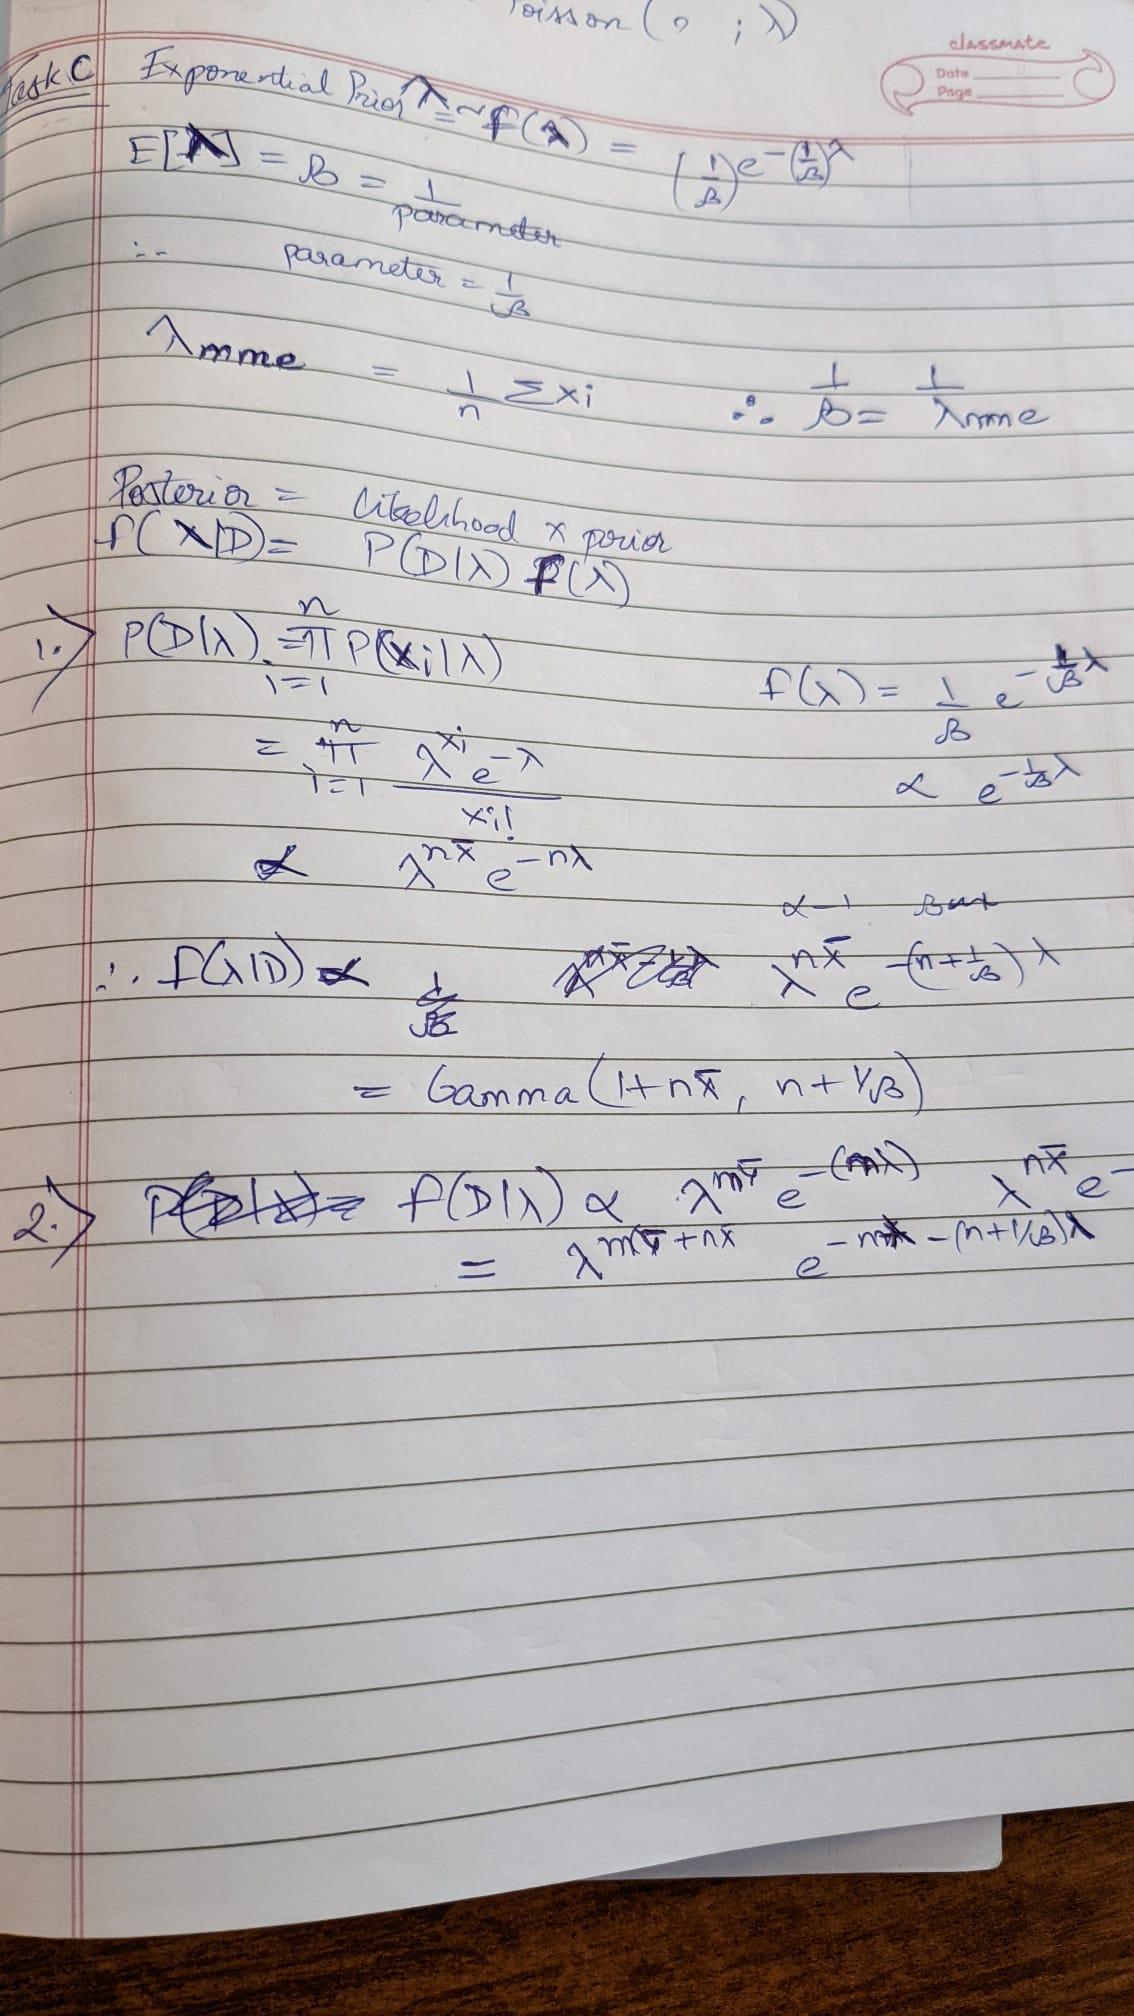
<!-- <img src="./WhatsApp%20Image%202022-05-15%20at%202.08.46%20PM.jpeg" alt="drawing" width="200"/> -->

In [1]:
import math
import pandas as pd

In [2]:
cases_deaths = pd.read_csv('./indiana_cases_deaths.csv')

In [3]:
cases_deaths.head()

,submission_date,new_case,new_death
0,2020-01-22,0.0,0.0
1,2020-01-23,0.0,0.0
2,2020-01-24,0.0,0.0
3,2020-01-25,0.0,0.0
4,2020-01-26,0.0,0.0


In [4]:
cases_deaths.dtypes

submission_date     object
new_case           float64
new_death          float64
dtype: object

In [5]:
cases_deaths['submission_date'] = pd.to_datetime(cases_deaths['submission_date'])

Combine cases and deaths

In [6]:
cases_deaths['combined_stats'] = cases_deaths['new_case'] + cases_deaths['new_death']

Peek into data from June

In [7]:
mask_first_four_weeks = (cases_deaths['submission_date'] >= '2020-06-01') & (cases_deaths['submission_date'] <= '2020-06-28')
cases_deaths[mask_first_four_weeks]

,submission_date,new_case,new_death,combined_stats
130,2020-06-01,256.0,8.0,264.0
131,2020-06-02,407.0,54.0,461.0
132,2020-06-03,475.0,10.0,485.0
133,2020-06-04,384.0,23.0,407.0
134,2020-06-05,482.0,28.0,510.0
135,2020-06-06,419.0,34.0,453.0
136,2020-06-07,400.0,11.0,411.0
137,2020-06-08,226.0,14.0,240.0
138,2020-06-09,410.0,24.0,434.0
139,2020-06-10,304.0,15.0,319.0


## Distributions

In [19]:
gamma = lambda x, alpha, beta: x**(alpha-1) * math.exp(-beta * x)
exponential = lambda x, theta: theta * math.exp(-theta*x)

## Compute lambda_mme and Prior

In [13]:
def compute_lambda_mme(data):
    return data.mean()

lambda_mme = int(compute_lambda_mme(cases_deaths[mask_first_four_weeks]['combined_stats']))
print(lambda_mme)

387


### Compute parameters of posterior given data

In [32]:
def compute_posterior_params(data, prior_alpha, prior_beta):
    x_bar = data.mean()
    n = len(data)
    alpha = n*x_bar + prior_alpha
    beta = n+prior_beta
    return alpha, beta

### Compute posterior for first 4 weeks

In [33]:
alpha_post, beta_post = compute_posterior_params(cases_deaths[mask_first_four_weeks]['combined_stats'],
                                                 1, 1/lambda_mme)

In [34]:
alpha_post, beta_post

(10841.0, 28.002583979328165)

### Compute posterior for 5th week 

In [40]:
fifth_week_first_index = cases_deaths[mask_first_four_weeks].index[-1] + 1
fifth_week = cases_deaths.iloc[fifth_week_first_index:fifth_week_first_index+7]
fifth_week

,submission_date,new_case,new_death,combined_stats
158,2020-06-29,298.0,5.0,303.0
159,2020-06-30,366.0,16.0,382.0
160,2020-07-01,358.0,9.0,367.0
161,2020-07-02,435.0,12.0,447.0
162,2020-07-03,528.0,18.0,546.0
163,2020-07-04,517.0,6.0,523.0
164,2020-07-05,576.0,6.0,582.0


In [41]:
alpha_post, beta_post = compute_posterior_params(fifth_week['combined_stats'],
                                                 alpha_post, beta_post)
alpha_post, beta_post

(19127.0, 47.002583979328165)

### Compute posterior for 6th week

In [43]:
sixth_week_first_index = fifth_week.index[-1]+1
sixth_week = cases_deaths.iloc[sixth_week_first_index:sixth_week_first_index+7]
sixth_week

,submission_date,new_case,new_death,combined_stats
165,2020-07-06,323.0,4.0,327.0
166,2020-07-07,295.0,20.0,315.0
167,2020-07-08,437.0,15.0,452.0
168,2020-07-09,512.0,7.0,519.0
169,2020-07-10,725.0,9.0,734.0
170,2020-07-11,779.0,8.0,787.0
171,2020-07-12,533.0,4.0,537.0


In [44]:
alpha_post, beta_post = compute_posterior_params(sixth_week['combined_stats'],
                                                 alpha_post, beta_post)
alpha_post, beta_post

(22798.0, 54.002583979328165)

### Compute posterior for 7th week

In [46]:
seventh_week_first_index = sixth_week.index[-1]+1
seventh_week = cases_deaths.iloc[seventh_week_first_index:seventh_week_first_index+7]
seventh_week

,submission_date,new_case,new_death,combined_stats
172,2020-07-13,425.0,2.0,427.0
173,2020-07-14,648.0,13.0,661.0
174,2020-07-15,685.0,10.0,695.0
175,2020-07-16,710.0,10.0,720.0
176,2020-07-17,733.0,8.0,741.0
177,2020-07-18,841.0,17.0,858.0
178,2020-07-19,917.0,2.0,919.0


In [47]:
alpha_post, beta_post = compute_posterior_params(seventh_week['combined_stats'],
                                                 alpha_post, beta_post)
alpha_post, beta_post

(27819.0, 61.002583979328165)

### Compute posterior for 8th week

In [48]:
eigth_week_first_index = seventh_week.index[-1]+1
eigth_week = cases_deaths.iloc[eigth_week_first_index:eigth_week_first_index+7]
eigth_week

,submission_date,new_case,new_death,combined_stats
179,2020-07-20,635.0,2.0,637.0
180,2020-07-21,710.0,21.0,731.0
181,2020-07-22,757.0,16.0,773.0
182,2020-07-23,929.0,16.0,945.0
183,2020-07-24,996.0,4.0,1000.0
184,2020-07-25,922.0,11.0,933.0
185,2020-07-26,852.0,8.0,860.0


In [49]:
alpha_post, beta_post = compute_posterior_params(eigth_week['combined_stats'],
                                                 alpha_post, beta_post)
alpha_post, beta_post

(33698.0, 68.00258397932816)